## Convolutional & Conditional VAEs

In this problem you will implement: 
1. a **convolutional** variational autoencoder
2. a (convolutional) **conditional** variational autoencoder,

trained on the MNIST dataset. 
The convolutional parameterization will help you achieve better marginal log likelihood. Using the conditional VAE, you'll be able to generate novel images of a specified class.


In [ ]:
%pylab inline
import torch
import torchvision
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST
from torch.distributions import MultivariateNormal

Populating the interactive namespace from numpy and matplotlib


In [ ]:
batch_size = 256

train_loader = torch.utils.data.DataLoader(
    MNIST('./data', train=True, download=True, 
          transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True
)
test_loader = torch.utils.data.DataLoader(
    MNIST('./data', train=False, transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True
)




---
# 1. Convolutional variational autoencoder (20 points)


Your task is to implement a VAE for MNIST, using a **convolutional network** in the encoder, and a **convolutional network** in the decoder.

- **Overall Goal:** achieve better estimated marginal likelihood than in the lab
  - Keep `z=20` as in the lab 


**Encoder**: you are free to design the convolutional network how you want. 
  - We used three `Conv2d + ReLU` layers, with an output size of `B x 64 x 7 x 7`.
  - Hint: Flatten the output of your convolutional network before mapping it to the encoder outputs, e.g. $\mu = \texttt{linear(flatten(conv(x)))}$


**Decoder**: you are free to design the convolutional network how you want. 
  - We used three `ConvTranspose2d + ReLU` layers, with an input size of `B x 64 x 7 x 7`.
  - Hint: Map the $\mathbf{z}$ input to the convolutional input size.
    - $\hat{x}=\texttt{deconv(reshape(linear(z)))}$

In [ ]:
class Encoder(nn.Module):
  def __init__(self, zdim):
    super().__init__()
    # TODO

  def forward(self, x):
    # TODO
    pass


class Decoder(nn.Module):
  def __init__(self, zdim):
    super().__init__()
    pass
  
  def forward(self, x):
    pass


class VAE(nn.Module):
  pass

**Loss**: does anything change from the lab?

In [ ]:
# hint: see lab

**Train on MNIST**: does anything change from the lab?

**Your task:** Implement training logic, and *produce a plot of training loss and a plot of validation loss* (x-axis: epoch, y-axis: loss). Each plot should contain three lines: total loss, BCE, and KL-divergence.

In [ ]:
device = torch.device("cuda:0")
zdim = 20        # use this
kl_weight = 1.0  # use this

In [ ]:
def train(epoch):
  pass

def valid(epoch):
  pass

# train, validate ..

# produce plot ...

### Evaluation
- **We provide the code below for sampling, interpolation, and marginal likelihood estimation**
- Sampling and interpolation: achieve similar to the lab (this is subjective, so the purpose is to check if something is *way off*)
- Marginal likelihood: achieve better than the lab



*Please ensure that `model` contains the model state that you will use for evaluation before running these.*

#### Sampling

*no code modification needed*

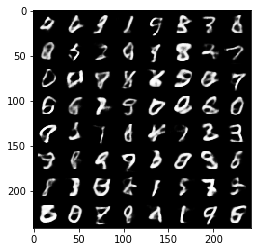

In [ ]:
from torchvision.utils import make_grid

N = 64
model.eval()

# Sample z~p(z)
z = torch.randn((N, model.encoder.zdim)).to(device)

# Decode
sample = model.decoder(z)

# Visualize
def show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

imgs = sample
grid = make_grid(imgs).detach().cpu()
show(grid)

#### Interpolation

*no code modification needed*

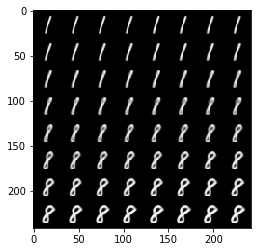

In [ ]:
model.eval()

x, y = next(train_loader.__iter__())
xhat, mu, logvar = model(x.cuda())
si, ei = np.random.choice(batch_size, size=2, replace=False)
start = mu[si]
end = mu[ei]

N = 64

zs = torch.zeros(N, model.encoder.zdim).to(device)
for i in range(N):
    zs[i] = i / (N) * start.data + (1 - i / (N) ) * end.data
xhat = model.decoder(zs)

imgs = xhat.unsqueeze(0).unsqueeze(0).view(N, 1, 28, 28)
grid = make_grid(imgs).detach().cpu()
show(grid)

#### Marginal likelihood

*no code modification needed*

In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)

eval_loader = torch.utils.data.DataLoader(
    MNIST('./data', train=False, transform=transforms.ToTensor()),
    batch_size=1, shuffle=True)

N_samples = 128

model.eval()
results = []
with torch.no_grad():
  for i, (x, y) in tqdm_notebook(enumerate(eval_loader), total=len(eval_loader)):
    x, y = next(eval_loader.__iter__())
    x = x.to(device).expand(N_samples, 1, 28, 28)

    # Obtain mu, logvar and sample z
    _, mu, logvar = model(x)
    z = mu + logvar.mul(0.5).exp()*torch.randn_like(mu)

    # Obtain xhat given the sampled z
    xhat = model.decoder(z)

    # Make a standard normal for p(z) and a normal for q(z|x)
    norm = MultivariateNormal(
        torch.zeros_like(mu[0]), 
        covariance_matrix=torch.diag(torch.ones_like(logvar[0]))
    )
    mvn = MultivariateNormal(
        mu[0], 
        covariance_matrix=torch.diag(logvar.exp()[0])
    )

    # Measure the (log) probabilities needed for the formula above
    log_pz = norm.log_prob(z)
    log_qzx = mvn.log_prob(z)
    x = x.view(xhat.size())
    log_pxz = -nn.functional.binary_cross_entropy(
        xhat, x, reduction='none'
    ).view(N_samples, -1).sum(1)

    # Compute the lowerbound (in log space)
    argsum = log_pxz + log_pz - log_qzx
    logpx = -np.log(N_samples) + torch.logsumexp(argsum, 0)
    results.append(logpx.item())

np.mean(results)



---

# 2. Conditional variational autoencoder (20 points)

### A. Model

The conditional VAE involves:
- $q_{\phi}(\mathbf{z}|\mathbf{x},c)$: "encoder"
- $p_{\theta}(\mathbf{x}|\mathbf{z},c)$: "decoder"
- $p(\mathbf{z})$: prior

In our case, $c\in \{0,...,9\}$ is a discrete variable (class label).

**Your task:** Implement a `CVAE` that has an `encoder`, `decoder`, and `reparameterization`.

*Hints*: 
  1. Represent $c$ using a `nn.Embedding` layer, and concatenate it to the representation of $\mathbf{x}$.
    - e.g. $\mu = \texttt{linear([conv(x); emb(c)])}$
  2. Represent `decoder` inputs $\mathbf{z},c$ similarly, as $[\mathbf{z};\text{emb}(c)]$.
    - $\hat{x}=\texttt{deconv(linear([z; emb(c)]))}$

Otherwise, everything else is the same as VAE (plus passing $c$ as an argument in the right places). You can use the same convolutional layers as above.

In [ ]:
class Encoder(nn.Module):
  def __init__(self, zdim, nclasses):
    super().__init__()
    # TODO

  def forward(self, x, c):
    # TODO
    return mu, logvar


class Decoder(nn.Module):
  def __init__(self, zdim, nclasses):
    super().__init__()
    # TODO
  
  def forward(self, z, c):
    # TODO
    return out


class CVAE(nn.Module):
  def __init__(self, zdim, nclasses):
    super().__init__()
    # TODO

  def reparameterize(self, mu, logvar):
    # TODO
    pass

  def forward(self, x, c):
    # TODO
    pass

**Loss:** same as VAE.

### C. Training

Train your conditional VAE model using your loss function on MNIST.

**Your task:** Implement training logic, and *produce a plot of training loss and a plot of validation loss* (x-axis: epoch, y-axis: loss). Each plot should contain three lines: total loss, BCE, and KL-divergence.


### D. Conditional generation

**Your task**: complete the code below to produce a grid of samples with 10 rows, where the $i$'th row has samples of class $i$.

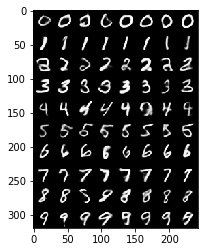

In [ ]:
from torchvision.utils import make_grid
def show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')


N = 8
model.eval()
grids = []
for y_ in range(10):
  
  # TODO (the ... does not imply it is a single line)
  # sample = ...

  grid = make_grid(sample).detach().cpu()
  grids.append(grid)

grid = torch.cat(grids, 1)
show(grid);